# Predicting the functional status of public water pumps in Tanzania

In [267]:
# to print all outputs in a cell instead of just the last one 
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = 'all'  # 'last_expr' to revert to default behaviour 

# import
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
#set figure size
plt.rcParams['figure.figsize'] = 15, 6
import seaborn as sns
sns.set_style('whitegrid')   

# to build specific estimators
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, StandardScaler
#from sklearn.pipeline import Pipeline 

from sklearn.model_selection import train_test_split #, GridSearchCV, PredefinedSplit

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
#from sklearn.metrics import f1_score

# to display all columns of dataframe 
pd.set_option('display.max_columns', 50)

In [268]:
# read data files
train_predictors = pd.read_csv('./input/training_X.csv')
train_target = pd.read_csv('./input/training_y.csv')
# create dataset with both label and independent variables
train_set = pd.concat([train_target[['status_group']], train_predictors], axis=1, sort=False)

## EDA
59400 observations x  40 features

In [269]:
print('Dimensions of training set = {:d} observations x  {:d} features'.format(train_predictors.shape[0], train_predictors.shape[1]))
train_set.sample(3)

Dimensions of training set = 59400 observations x  40 features


,status_group,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
17293,functional,68350,0.0,2012-10-24,Tasad,0,DWE,0.000000,-2.000000e-08,Swkondari Dutwa,0,Lake Victoria,Dutwa,Shinyanga,17,1,Bariadi,Nyakabindi,0,NaN,GeoData Consultants Ltd,Parastatal,NaN,False,0,afridev,afridev,handpump,parastatal,parastatal,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2876,functional,72518,0.0,2013-02-13,Snv,730,DWE,36.130036,-1.021851e+01,Kwa Fukara,0,Rufiji,Msimbazi,Ruvuma,10,5,Namtumbo,Mgombasi,250,True,GeoData Consultants Ltd,WUG,NaN,False,1998,nira/tanira,nira/tanira,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
25147,non functional,23007,0.0,2013-01-29,Fini Water,368,Fini Water,38.742729,-1.038770e+01,Nyambila,0,Ruvuma / Southern Coast,Tupendane,Lindi,8,3,Nachingwea,Namatula,206,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,other,other


### Target

In [270]:
train_set['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

### Independant variables

Several categorical variables have missing values: funder, installer, subvillage, public meeting, scheme_management and scheme_name, permit.  
There is apparently no missing values for numerical variables.  
The variables *id* (id of each pump) and *recorded_by* (only one distinct value) have no explicative value and can ignored.  
The variables *wpt_name* (name of the waterpoint) and *subvillage* have a very high number of unique values. They can be ignored too. 

In [271]:
summary = pd.DataFrame(np.array([train_predictors.dtypes, 
                                 train_predictors.isnull().sum(), 
                                 train_predictors.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                                 
                       columns=np.array(list(train_predictors)))
display(summary)

col_to_drop = ['id', 'recorded_by', 'wpt_name', 'subvillage']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
Dtype,int64,float64,object,object,int64,object,float64,float64,object,int64,object,object,object,int64,int64,object,object,int64,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
NbrNullValues,0,0,0,3635,0,3655,0,0,0,0,0,371,0,0,0,0,0,0,3334,0,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NbrDistinctVal,59400,98,356,1897,2428,2145,57516,57517,37400,65,9,19287,21,27,20,125,2092,1049,2,1,12,2696,2,55,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6


### Numerical variables

Several numerical variables preset a high number of 0 values, which probably corresponds to missing value.

In [272]:
# extract all numerical variables plus target
train_num = train_predictors.select_dtypes(include=np.number)
train_num = pd.concat([train_num, train_target], axis=1)
train_num = train_num.drop(labels='id', axis=1)

train_num.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [273]:
# define here function to do some eda on numerical variables
def eda_numerical_variable(col, transform='none'):
    # create df and add column coding for 0 value
    df = train_num[['status_group',col]].copy()
    df['is_zero'] = (train_num[col] == 0)

    # frequency of 0 value
    print('NUMERICAL VARIABLE: ' + col)
    print('percentage of 0 value = {:.2f}%'.format(df[df.is_zero == True].shape[0]/train_num.shape[0]*100))

    # is distribution of label values different between variable group with 0 or non-0 value?
    print('\nDistribution of label values for predictor with NON-ZERO value')
    display(df.loc[df.is_zero == False, 'status_group'].value_counts(normalize=True))
    print('Distribution of label values for predictor with ZERO value')
    display(df.loc[df.is_zero == True, 'status_group'].value_counts(normalize=True))
    # similar result but as plot
    sns.countplot(x='status_group',hue='is_zero', data=df);
   
    if transform == 'log':
        df[col] = df[col].apply(lambda x: np.log(x))

    sns.catplot(x='status_group', y=col, data=df[df.is_zero == False], kind='box');

#### amount_tsh
this is the total head of the pump.
* high percentage of 0 (ie missing value)
* distribution of target differs significantly between groups with valid value and with missing value. Information of whether value is missing or not should be included as new variable
* distribution of valid values for different differs label  

NUMERICAL VARIABLE: amount_tsh
percentage of 0 value = 70.10%

Distribution of label values for predictor with NON-ZERO value


functional                 0.706773
non functional             0.221778
functional needs repair    0.071449
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.473258
non functional             0.453541
functional needs repair    0.073201
Name: status_group, dtype: float64

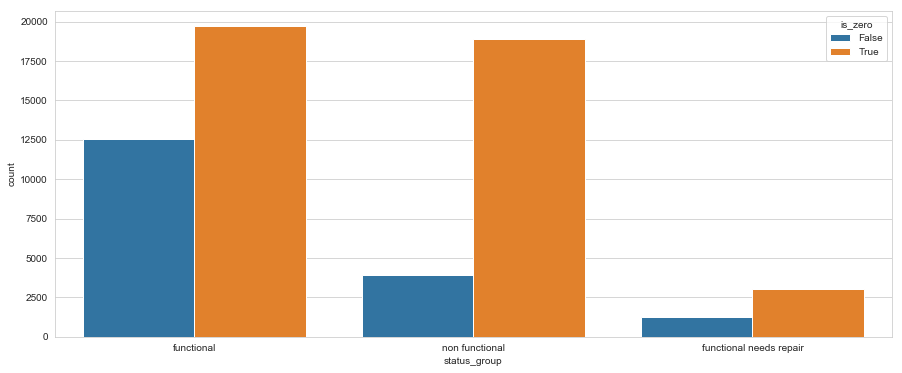

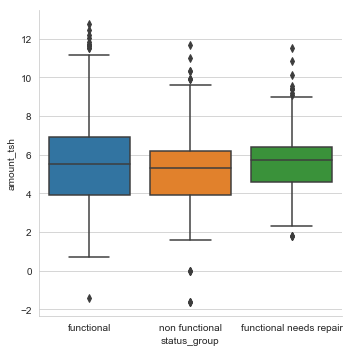

In [274]:
eda_numerical_variable('amount_tsh', 'log')

#### gps_height
This is the altitude of the well.  
Label *functional needs repair* may be underrepresented for altitude below 750. 

NUMERICAL VARIABLE: gps_height
percentage of 0 value = 34.41%

Distribution of label values for predictor with NON-ZERO value


functional                 0.559263
non functional             0.375186
functional needs repair    0.065551
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.512232
non functional             0.401507
functional needs repair    0.086261
Name: status_group, dtype: float64

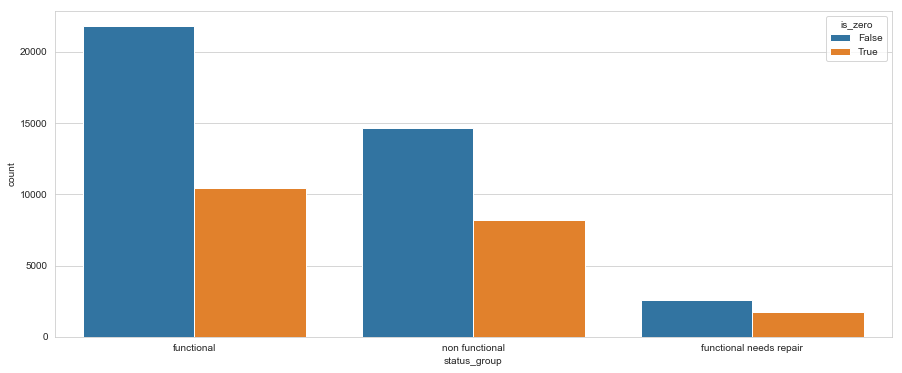

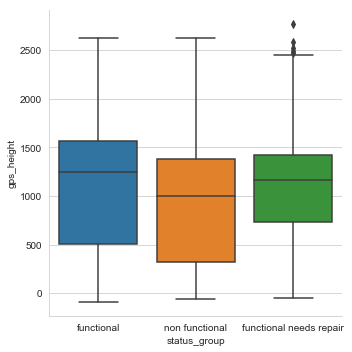

In [275]:
eda_numerical_variable('gps_height')

#### longitude
Some missing value. Higher frequency of *functional needs repair* status for missing value. 

NUMERICAL VARIABLE: longitude
percentage of 0 value = 3.05%

Distribution of label values for predictor with NON-ZERO value


functional                 0.545061
non functional             0.386678
functional needs repair    0.068261
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.480132
non functional             0.306843
functional needs repair    0.213024
Name: status_group, dtype: float64

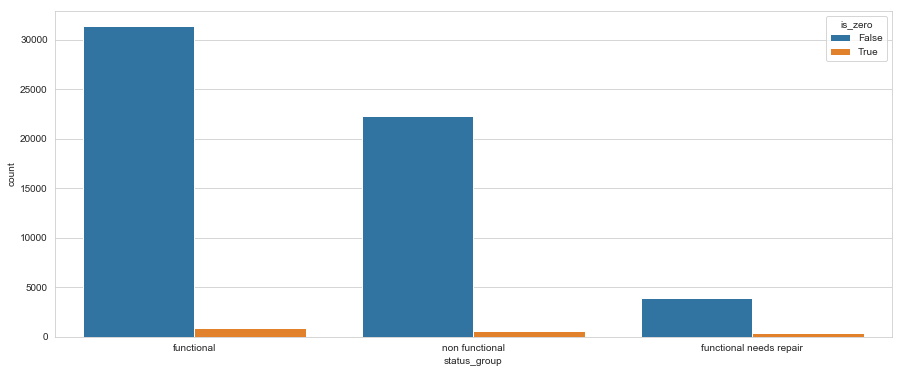

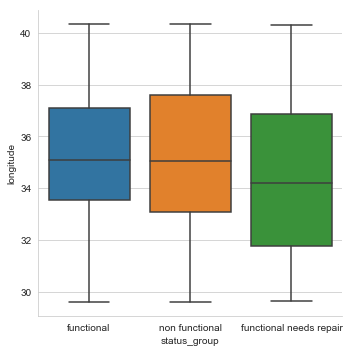

In [276]:
eda_numerical_variable('longitude')
col_to_drop.append('longitude')

#### latitude
no missing value and not obvious correlation with label. We will drop it.

NUMERICAL VARIABLE: latitude
percentage of 0 value = 0.00%

Distribution of label values for predictor with NON-ZERO value


functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


Series([], Name: status_group, dtype: float64)

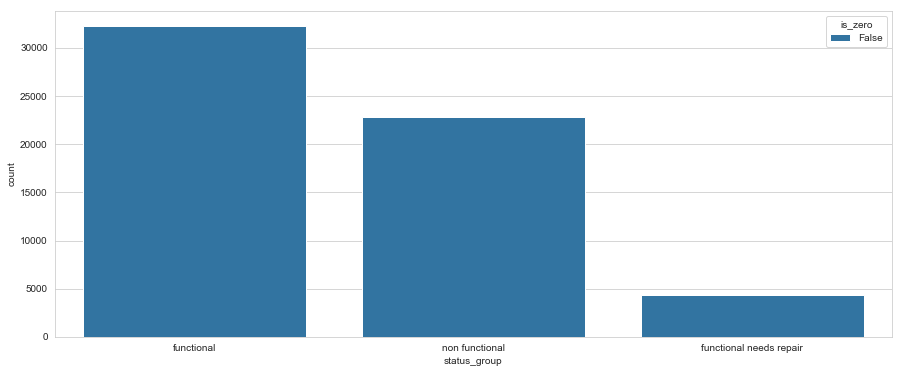

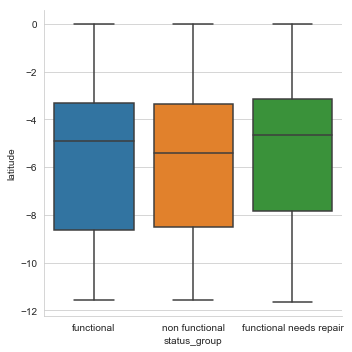

In [277]:
eda_numerical_variable('latitude')
col_to_drop.append('latitude')

#### num_private
meaning unknown. Very high frequency of 0 value. Drop or treat as categorical.

NUMERICAL VARIABLE: num_private
percentage of 0 value = 98.73%

Distribution of label values for predictor with NON-ZERO value


functional                 0.608983
non functional             0.327609
functional needs repair    0.063408
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.542230
non functional             0.384973
functional needs repair    0.072796
Name: status_group, dtype: float64

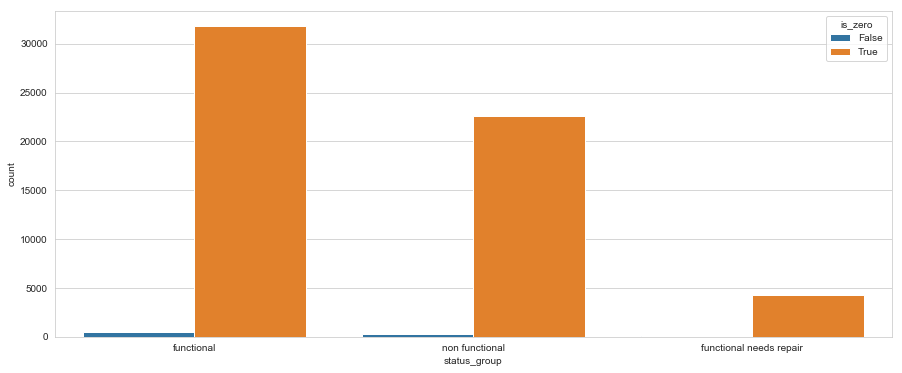

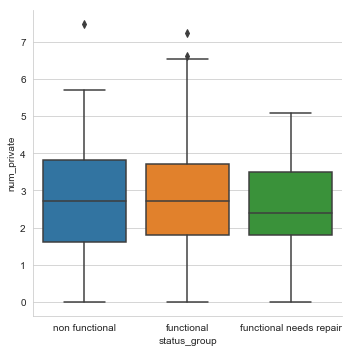

In [278]:
eda_numerical_variable('num_private', 'log')
col_to_drop.append('num_private')

#### region_code and district_code
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
Numerical values but unordered. Process as categorical variables.

#### population
no impact of missing/valid value  


NUMERICAL VARIABLE: population
percentage of 0 value = 35.99%

Distribution of label values for predictor with NON-ZERO value


functional                 0.551961
non functional             0.381178
functional needs repair    0.066861
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.527291
non functional             0.389692
functional needs repair    0.083018
Name: status_group, dtype: float64

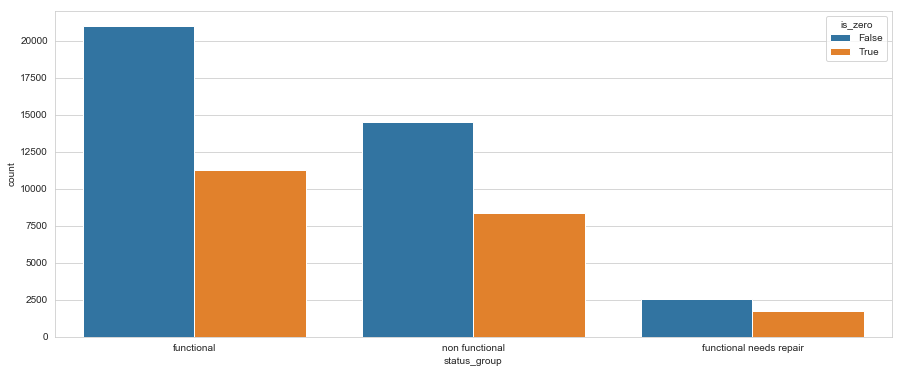

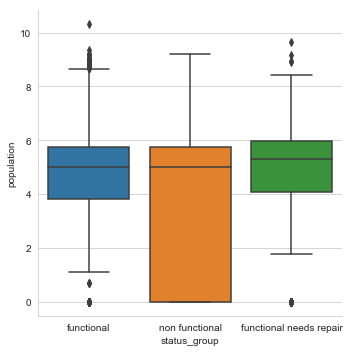

In [279]:
eda_numerical_variable('population', 'log')

#### construction_year
no need of NAN indicator

NUMERICAL VARIABLE: construction_year
percentage of 0 value = 34.86%

Distribution of label values for predictor with NON-ZERO value


functional                 0.560957
non functional             0.373704
functional needs repair    0.065338
Name: status_group, dtype: float64

Distribution of label values for predictor with ZERO value


functional                 0.509682
non functional             0.403931
functional needs repair    0.086388
Name: status_group, dtype: float64

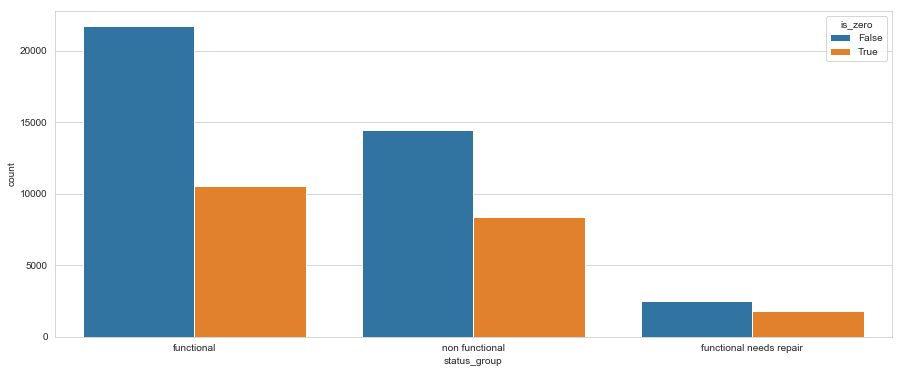

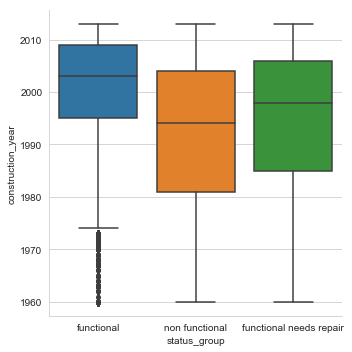

In [280]:
eda_numerical_variable('construction_year')

#### Summary
Plan for Feature Engineering of numerical variables:
* drop variables 'longitude', 'latitude', 'num_private'
* replace 0 with NaN for variables 'amount_tsh', 'gps_height', 'population', 'construction_year'
* create missing indicator for variable 'amount_tsh'


### Categorical variables

In [281]:
train_cat = train_predictors.copy()
train_cat = pd.concat([train_cat, train_target], axis=1)
train_cat.drop(labels=['longitude', 'latitude', 'num_private',
                       'amount_tsh', 'gps_height', 'population', 'construction_year',
                       'id', 'recorded_by', 'wpt_name', 'subvillage'], axis=1, inplace=True)

train_cat.head(10)

,date_recorded,funder,installer,basin,region,region_code,district_code,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,2011-03-14,Roman,Roman,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,True,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,2013-03-06,Grumeti,GRUMETI,Lake Victoria,Mara,20,2,Serengeti,Natta,NaN,Other,NaN,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,2013-02-25,Lottery Club,World vision,Pangani,Manyara,21,4,Simanjiro,Ngorika,True,VWC,Nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,2013-01-28,Unicef,UNICEF,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,True,VWC,NaN,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,2011-07-13,Action In A,Artisan,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,True,NaN,NaN,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
5,2011-03-13,Mkinga Distric Coun,DWE,Pangani,Tanga,4,8,Mkinga,Moa,True,VWC,Zingibali,True,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
6,2012-10-01,Dwsp,DWSP,Internal,Shinyanga,17,3,Shinyanga Rural,Samuye,True,VWC,NaN,True,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
7,2012-10-09,Rwssp,DWE,Lake Tanganyika,Shinyanga,17,3,Kahama,Chambo,True,NaN,NaN,True,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
8,2012-11-03,Wateraid,Water Aid,Lake Tanganyika,Tabora,14,6,Tabora Urban,Itetemia,True,VWC,NaN,True,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
9,2011-08-03,Isingiro Ho,Artisan,Lake Victoria,Kagera,18,1,Karagwe,Kaisho,True,NaN,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [282]:
summary = pd.DataFrame(np.array([train_cat.dtypes, 
                                 train_cat.isnull().sum(), 
                                 train_cat.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                                 
                       columns=np.array(list(train_cat)))
display(summary)

# code NaN value as 'missing' 
train_cat.fillna(value='missing', inplace=True)

,date_recorded,funder,installer,basin,region,region_code,district_code,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
Dtype,object,object,object,object,object,int64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
NbrNullValues,0,3635,3655,0,0,0,0,0,0,3334,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NbrDistinctVal,356,1897,2145,9,21,27,20,125,2092,2,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3


#### High cardinality variables
5 variables with high cardinality: 'funder', 'installer', 'lga', 'ward', 'scheme_name' (ignore this one)
will be process during FE by mapping them to a numeric function. Ignore them during EDA

In [283]:
col_high_cardinality = ['funder', 'installer', 'lga', 'ward']

#### basin
keep it, transform to dummy variables or treat as high cardinality

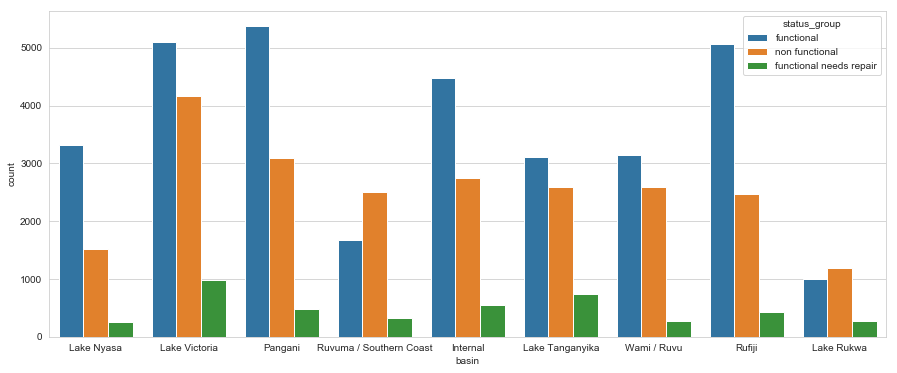

In [284]:
sns.countplot(x='basin', hue='status_group', data=train_cat);
col_to_dummies = ['basin']

#### region and region_code
keep one of them, treat as high cardinality

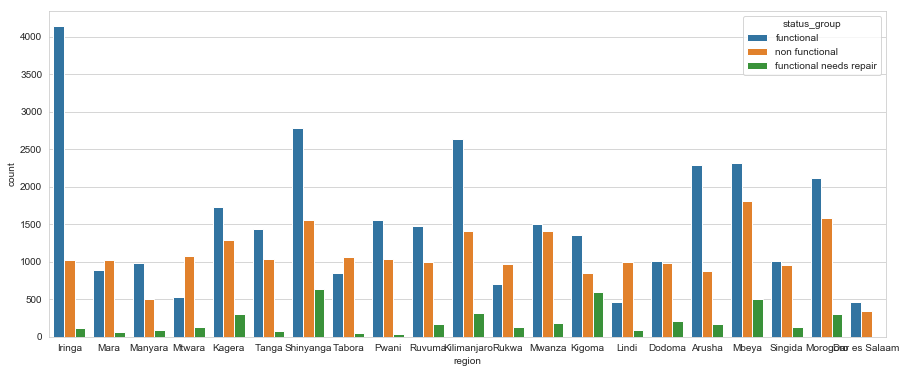

In [285]:
sns.countplot(x='region', hue='status_group', data=train_cat);
col_to_drop.append('region')
col_high_cardinality.append('region_code')

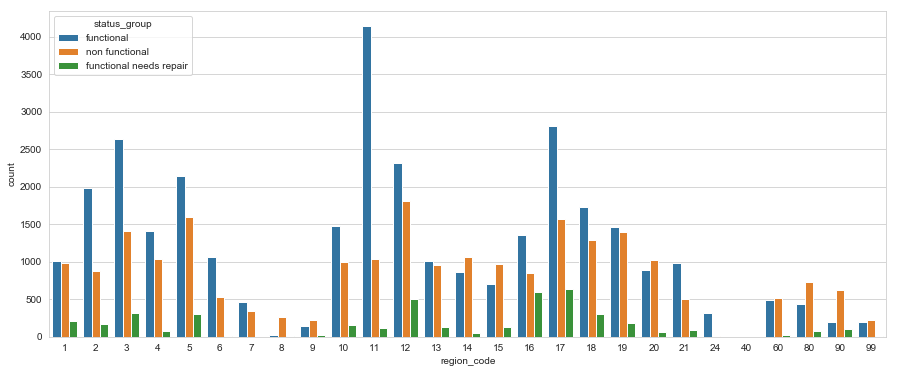

In [286]:
sns.countplot(x='region_code', hue='status_group', data=train_cat);

#### district_code
probably not very informative but process it as high cardinality

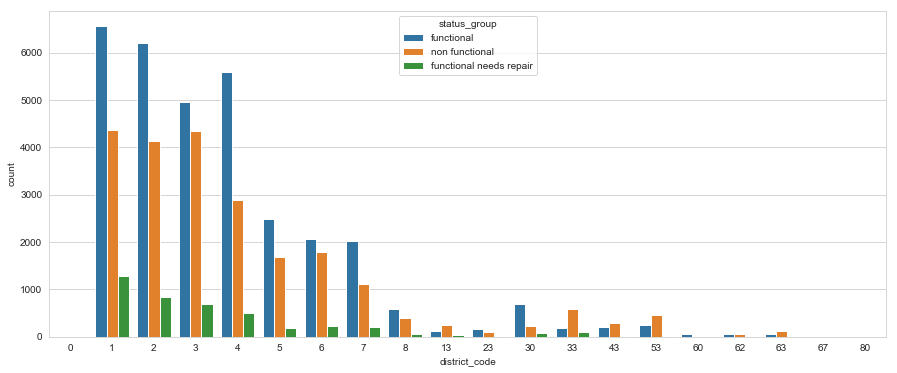

In [287]:
sns.countplot(x='district_code', hue='status_group', data=train_cat);
col_high_cardinality.append('district_code')

#### public meeting
some impact, keep it and transform to dummy with NAN indicator

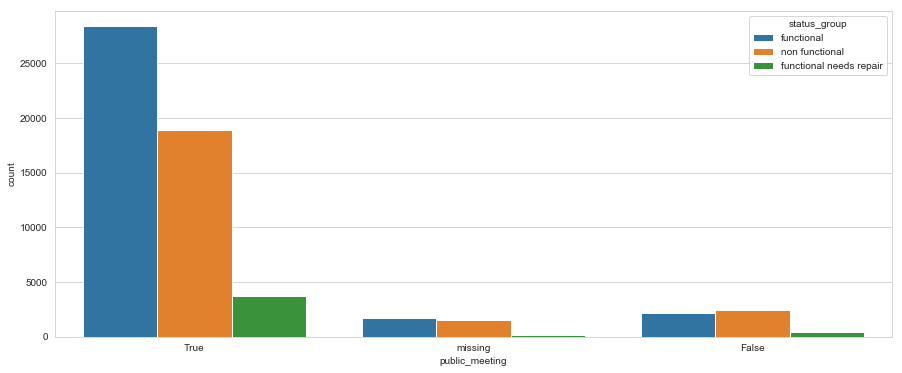

In [288]:
sns.countplot(x='public_meeting', hue='status_group', data=train_cat);

#### scheme_management and scheme_name
potentially some impact for scheme_management  
ignore scheme_name as too many missing values

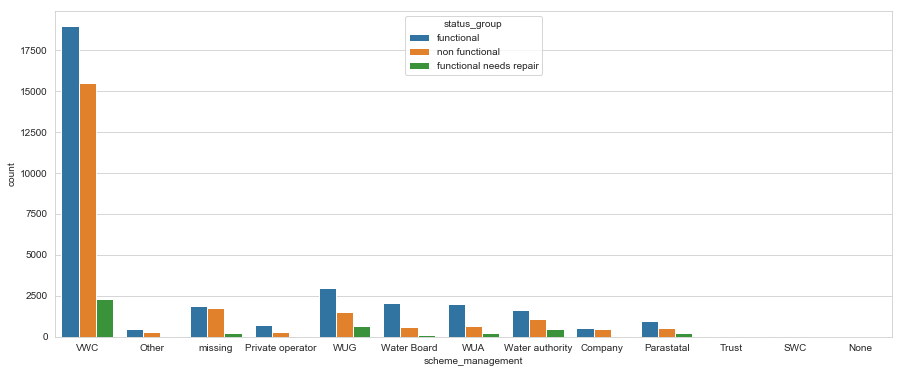

In [289]:
sns.countplot(x='scheme_management', hue='status_group', data=train_cat);
col_to_drop.append('scheme_name')
col_to_dummies.append('scheme_management')

#### permit 
not sure if any impact, but keep it and transform to dummy with NAN indicator

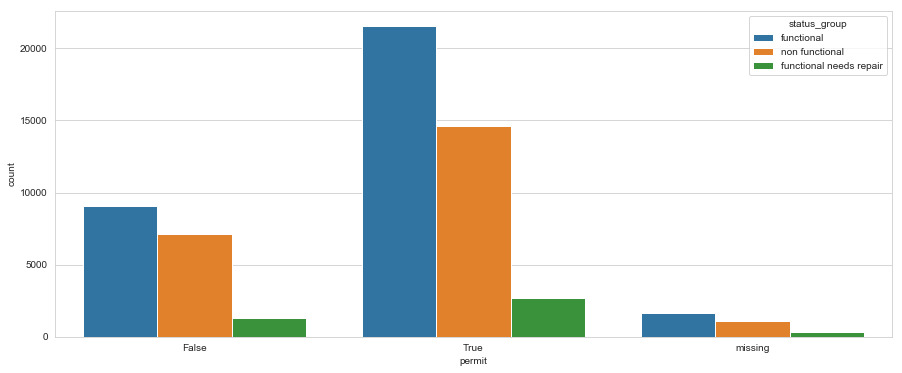

In [290]:
sns.countplot(x='permit', hue='status_group', data=train_cat);

#### variables for extraction type
keep only 'extraction_type_group'.  
discard 'extraction_type' and 'extraction_type_class'

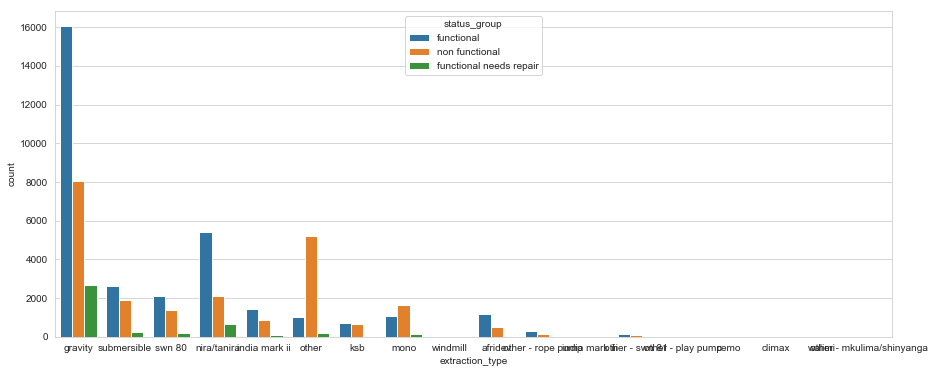

In [291]:
sns.countplot(x='extraction_type', hue='status_group', data=train_cat);
col_to_drop.append('extraction_type')

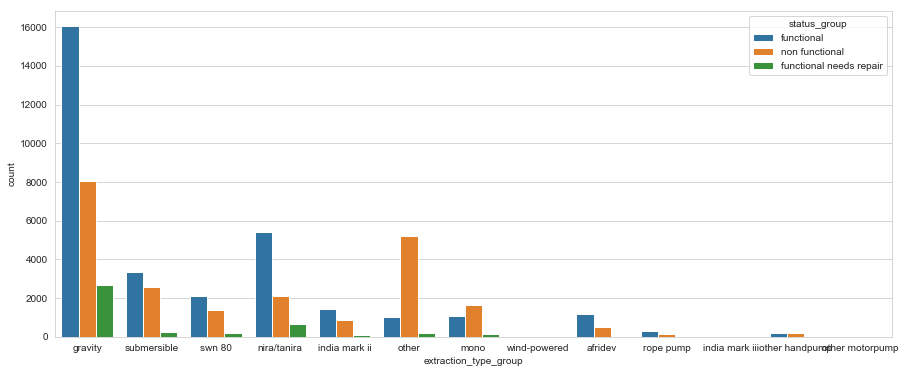

In [292]:
sns.countplot(x='extraction_type_group', hue='status_group', data=train_cat);
col_to_dummies.append('extraction_type_group')

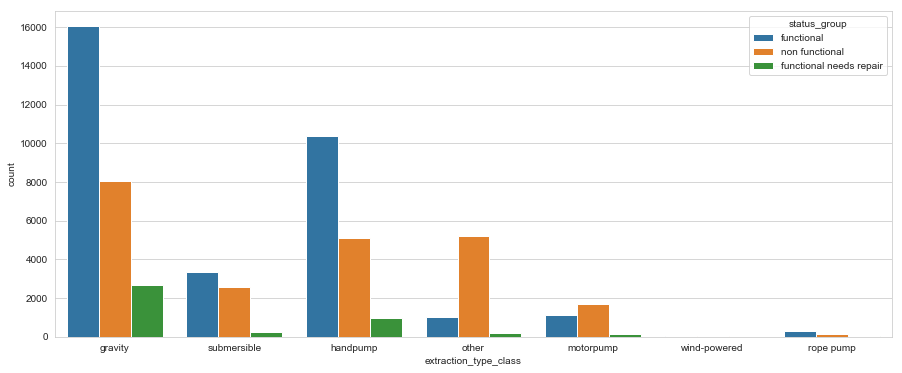

In [293]:
sns.countplot(x='extraction_type_class', hue='status_group', data=train_cat);
col_to_drop.append('extraction_type_class')

#### management and management_group
drop both, at least for now

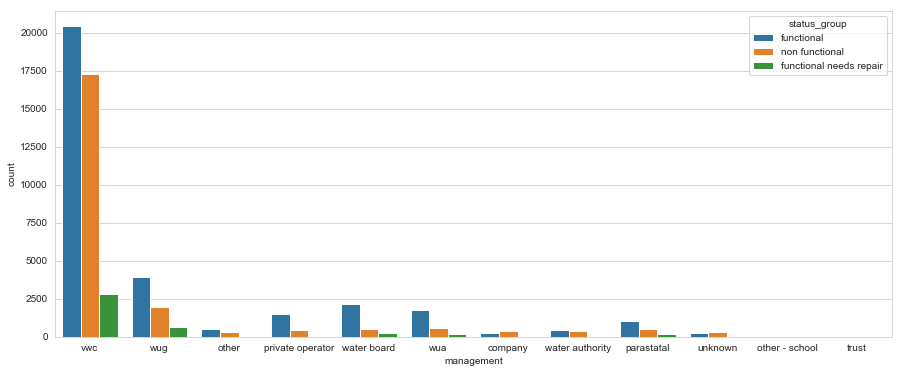

In [294]:
sns.countplot(x='management', hue='status_group', data=train_cat);

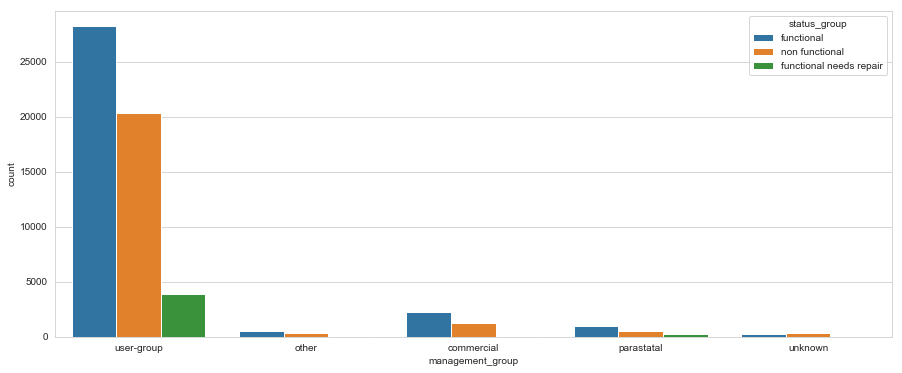

In [295]:
sns.countplot(x='management_group', hue='status_group', data=train_cat);
col_to_drop.append('management')
col_to_drop.append('management_group')

#### payment and payment_type
similar information, keep only one 'payment_type'

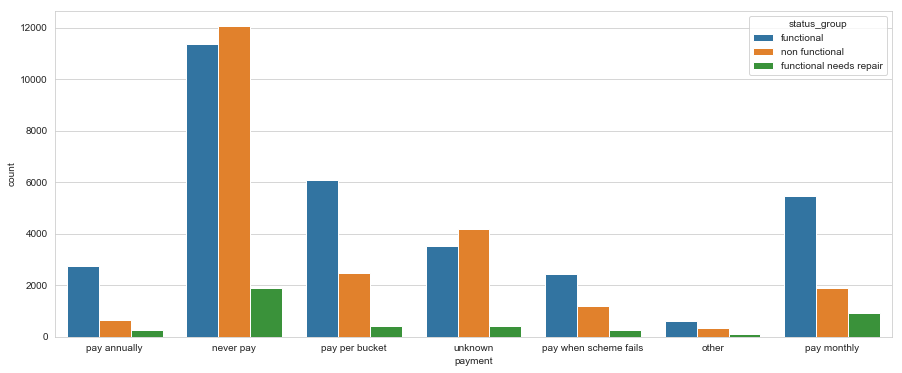

In [296]:
sns.countplot(x='payment', hue='status_group', data=train_cat);
col_to_drop.append('payment')

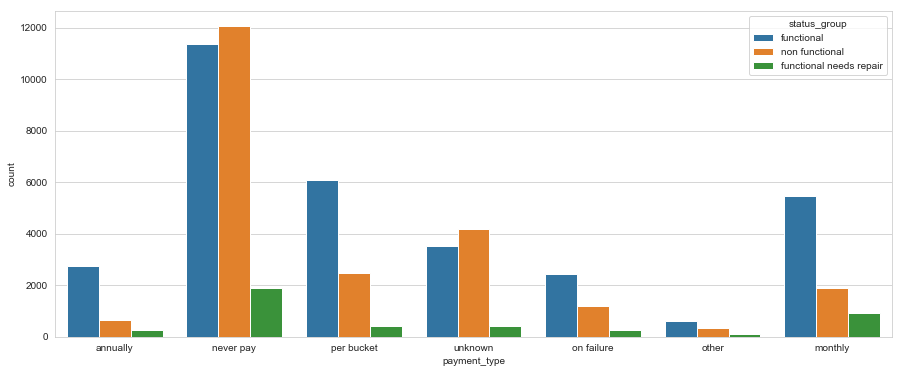

In [297]:
sns.countplot(x='payment_type', hue='status_group', data=train_cat);
col_to_dummies.append('payment_type')

#### water_quality and quality_group
keep only quality_group and transform to dummy variables

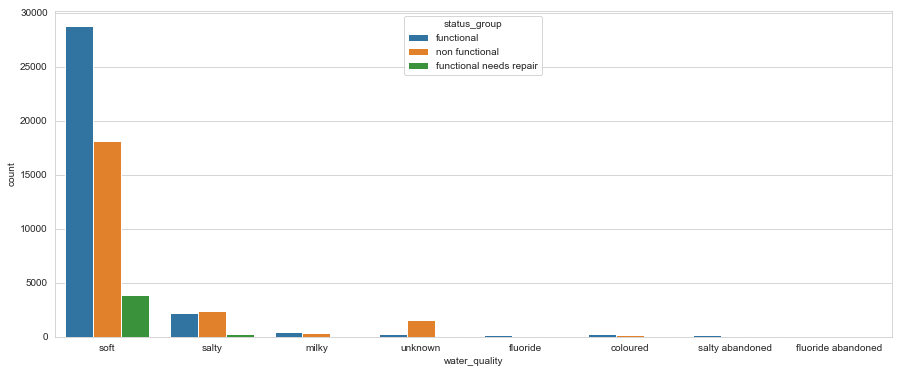

In [298]:
sns.countplot(x='water_quality', hue='status_group', data=train_cat);
col_to_drop.append('water_quality')

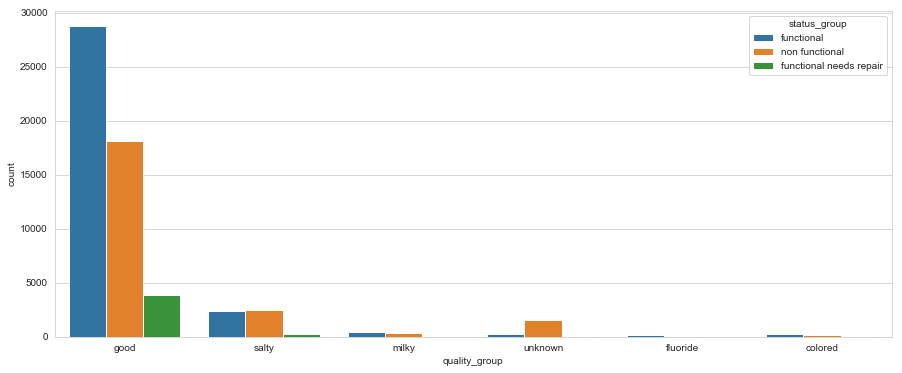

In [299]:
sns.countplot(x='quality_group', hue='status_group', data=train_cat);
col_to_dummies.append('quality_group')

#### quantity and quantity_group
same information, keep only quantity_group and transform to dummy variables

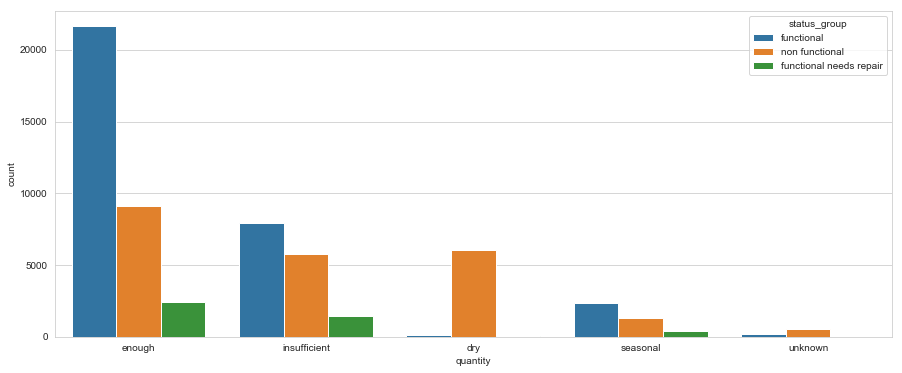

In [300]:
sns.countplot(x='quantity', hue='status_group', data=train_cat);
col_to_drop.append('quantity')

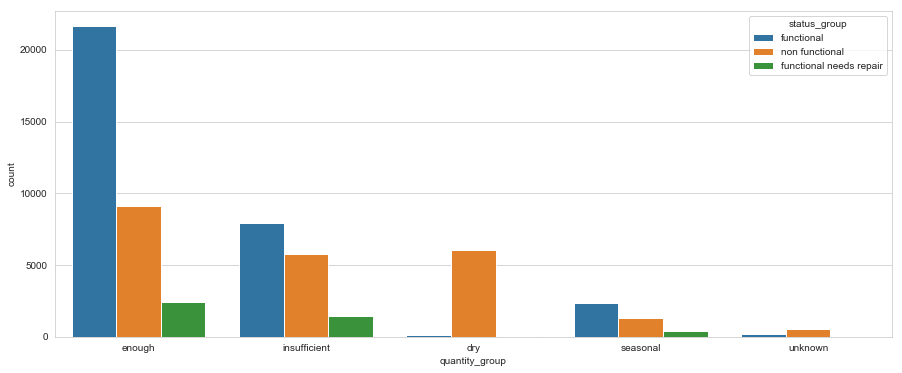

In [301]:
sns.countplot(x='quantity_group', hue='status_group', data=train_cat);
col_to_dummies.append('quantity_group')

#### source, source_type, source_class
keep only source which is the most informative  
transform to dummy variables

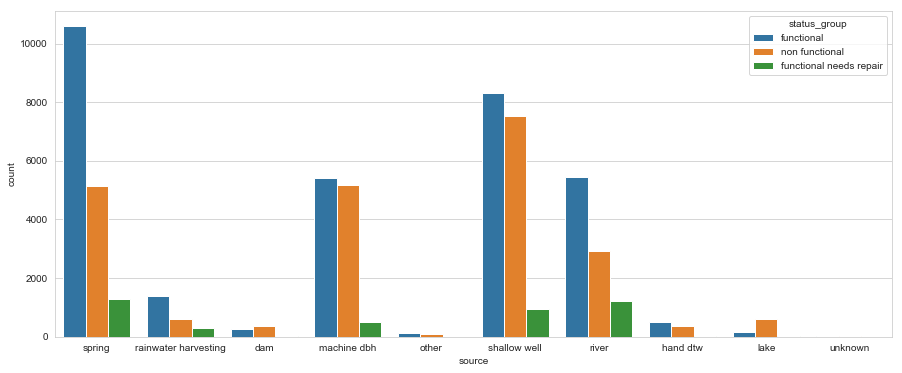

In [302]:
sns.countplot(x='source', hue='status_group', data=train_cat);
col_to_dummies.append('source')

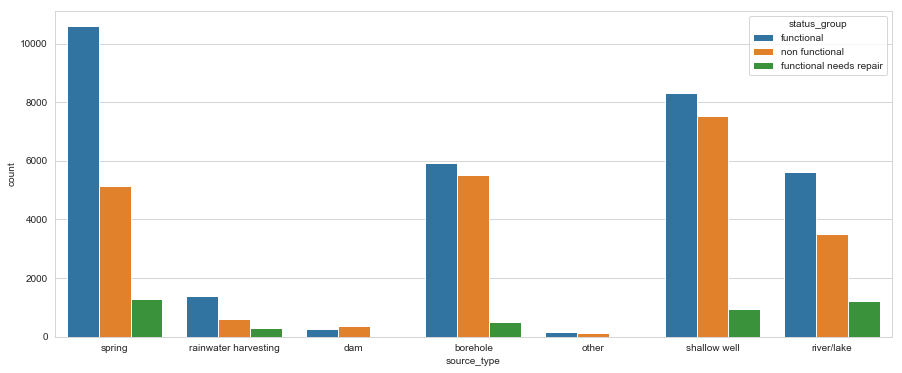

In [303]:
sns.countplot(x='source_type', hue='status_group', data=train_cat);

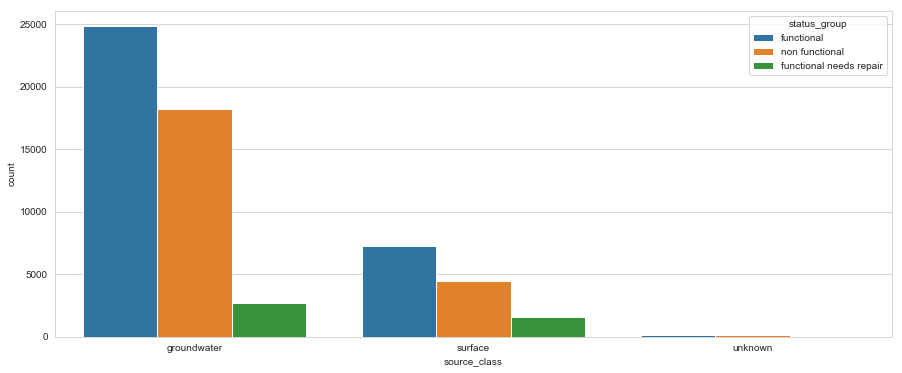

In [304]:
sns.countplot(x='source_class', hue='status_group', data=train_cat);
col_to_drop.append('source_type')
col_to_drop.append('source_class')

#### waterpoint_type and waterpoint_type_group
keep only waterpoint_type, process as dummy variable

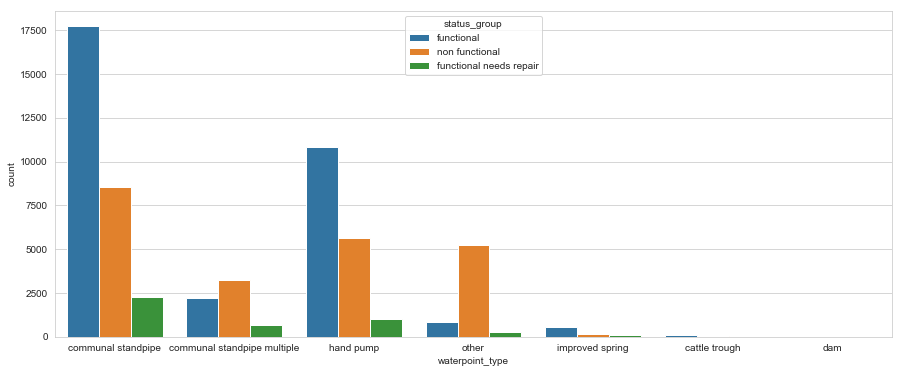

In [305]:
sns.countplot(x='waterpoint_type', hue='status_group', data=train_cat);
col_to_dummies.append('waterpoint_type')

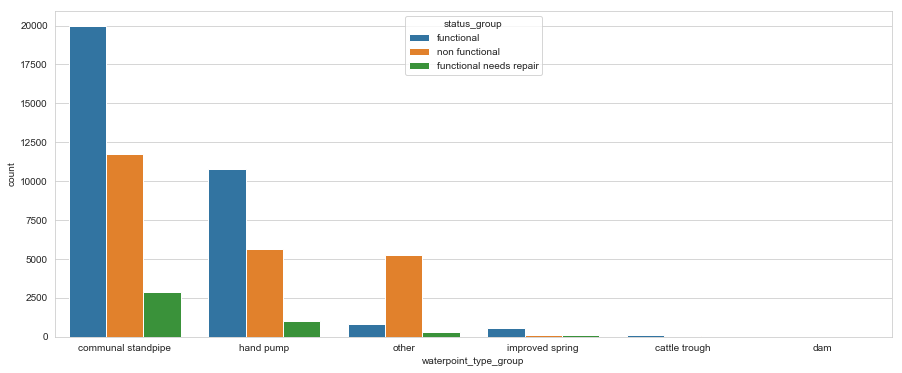

In [306]:
sns.countplot(x='waterpoint_type_group', hue='status_group', data=train_cat);
col_to_drop.append('waterpoint_type_group')

#### TODO EDA and FE for date_recorded

#### Summary
Plan for Feature Engineering of categorical variables:
* drop 'region', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_class', 'payment', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group'
* drop for now 'management', 'management_group'
* process as high cardinality 'funder', 'installer', 'lga', 'ward' and 'region_code', 'district_code', 'extraction_type_group'
* transform to dummy variables 'basin', 'payment_type', 'quality_group', 'quantity_group', 'source', 'waterpoint_type'
* transform to dummy variables 'public_meeting', 'permit'

## Feature Engineering

In [307]:
# handle the target with mapping
train_target['status_group'] = train_target['status_group'].map({'functional': 0, 
                                                                 'functional needs repair': 1, 
                                                                 'non functional': 2})

This dataset contains several categorical variables with very high cardinality, like for example *funder* with 1897 unique values. There are 3 approaches possible to handle this type of features:
* group together values that have close meaning (this is however not possible for variables like *funder* for which there is no clear proximity measure between different values)
* discard values with low frequencies (possible, but this would probably be unsufficient to reduce enough the number of unique values)
* **transform the initial feature into a continuous numerical feature**  

We will use option 3, and we define 3 functions $f_F$, $f_R$ and $f_N$:
$$f_F(x) = \frac{N_F(x) + p_F}{N(x) + 1}$$  
$$f_R(x) = \frac{N_R(x) + p_R}{N(x) + 1}$$  
$$f_N(x) = \frac{N_N(x) + p_N}{N(x) + 1}$$ 
where:
* $x$ is a given value of the high cardinality variable V, 
* $N_F(x)$, $N_R(x)$ and $f_N(x)$ are the number of observations with V=x and respectively equal to Functional, Repair, and Non Functional 
* $N(x)$ is the total number of observations with V=X, with $N(x) = N_F(x) + N_R(x) + f_N(x)$
* $p_F$, $p_R$ and $p_N$ are the frequencies over the full set of status Functional, Repair, and Non Functional  
  
Now, it is easy to see that the sum of $f_F$, $f_R$ and $f_N$ is equal to 1 and that these 3 functions can be considered as probabilities of each status: 
$$f_F(x) + f_R(x) + f_N(x) = \frac{N_F(x) + p_F + N_R(x) + p_R + N_N(x) + p_N}{N(x) + 1}
= \frac{N_F(x) + N_R(x) + N_N(x) + p_F + p_R + p_N}{N(x) + 1} = \frac{N(x) + 1}{N(x) + 1}$$  

The rationale for these functions is:
* their value gets closer to the observed frequencies $\frac{N_F(x)}{N(x)}$ as the number of observations $N(x)$ increases. Thus they are putting more weight on frequent values 
* they have an intuitive meaning as estimation of probabilities
* they are defined even if the value x is not included in the training set  

In [308]:
# define transformer to transform high cardinality variables to numerical functions

#### TODO remove hardcoded labels

class HighCardinalityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._frequencies = {}
        self._label_values = []
        self._mapper = {}
        pass
    
    def fit(self, X, y):
        # both X and y must be DF
        # convert y to string to have a fixed and known type  
        y_str = y.astype(str)
        
        # self._label_values = ['functional', 'functional needs repair', 'non functional']
        self._label_values = ['0', '1', '2']        
        
        # compute frequencies over full data
        self._default_frequencies = {}
        for status in self._label_values: 
            self._frequencies[status] = np.count_nonzero(y_str == status) / y_str.shape[0]  
        
        # get list of all columns in X 
        columns_to_map = list(X)
        
        self._mapper = {}
        for col in columns_to_map:
            # create df with the variable to map and the label
            df = pd.concat([X[col],y], axis=1)
            df.rename(columns={y.columns.values[0]: 'y'}, inplace=True)
            
            # replace y with 3 columns 'y_functional', 'y_functional needs repair', 'y_non functional' with counts 
            df = pd.get_dummies(data=df, columns=['y'])
            df = df.groupby(col).sum()
            
#            df['count'] = df['y_functional'] +  df['y_functional needs repair'] + df['y_non functional']
            df['count'] = df['y_0'] +  df['y_1'] + df['y_2']            
            # calculate the 3 probability estimates
#            df['functional'] = (df['y_functional'] + self._frequencies['functional']) / (df['count'] + 1)
#            df['functional needs repair'] = (df['y_functional needs repair'] + self._frequencies['functional needs repair']) / (df['count'] + 1)
#            df['non functional'] = (df['y_non functional'] + self._frequencies['non functional']) / (df['count'] + 1) 
            df['0'] = (df['y_0'] + self._frequencies['0']) / (df['count'] + 1)
            df['1'] = (df['y_1'] + self._frequencies['1']) / (df['count'] + 1)
            df['2'] = (df['y_2'] + self._frequencies['2']) / (df['count'] + 1) 
            
            # create mapper with format:
            #     {'col1': {'functional': {val1: f1, val2: f2, ...},
            #               'functional needs repair': {val1: f1, val2: f2, ...},
            #               'non functional': {val1: f1, val2: f2, ...}}, 
            #      'col2': ...}
            self._mapper[col] = df[['0', '1', '2']].to_dict()
            
        return self
    
    def transform(self, X, y=None):
        res = X.copy()
        
        for col_name in list(X):
            for y_name in self._label_values:
                mapper = self._mapper[col_name][y_name]
                new_col = col_name + '_f_' + y_name
                res[new_col] = X[col_name].map(mapper)
                
                # fill NA value with frequency of corresponding status - TODO not tested 
                res[new_col] = res[new_col].fillna(value=self._frequencies[y_name])
                
        return res
    
    def get_frequencies(self):        
        return self._frequencies
    
    def get_mapper(self):
        return self._mapper   
    
# example: transform 2 categorical values to numeric functions    
hct = HighCardinalityTransformer()
hct.fit(train_predictors[['region','lga']], train_target[['status_group']])
res = hct.transform(train_predictors[['region','lga']])
res.head(5)

HighCardinalityTransformer()

,region,lga,region_f_0,region_f_1,region_f_2,lga_f_0,lga_f_1,lga_f_2
0,Iringa,Ludewa,0.782161,0.023243,0.194596,0.774413,0.019598,0.205990
1,Mara,Serengeti,0.450022,0.030494,0.519484,0.592110,0.037758,0.370131
2,Manyara,Simanjiro,0.623449,0.060652,0.315899,0.581046,0.016416,0.402538
3,Mtwara,Nanyumbu,0.303029,0.072832,0.624139,0.267567,0.000457,0.731976
4,Kagera,Karagwe,0.520815,0.091671,0.387514,0.530496,0.058384,0.411119


#### prepare data


In [309]:
def prepare_X(X):
    # discard variables which are not informative enough
    print('dropping variables: {}'.format(col_to_drop))
    df = X.drop(labels=col_to_drop, axis=1)
    
    # TODO - REMOVE ONCE DONE 
    df.drop(labels='date_recorded', axis=1, inplace=True)
    
    # replace 0 with NaN for selected variables
    for col in ['amount_tsh', 'gps_height', 'population', 'construction_year']:
        df.loc[:,col] = df[col].replace(to_replace=0, value=np.nan)
       
    # add missing indicators
    for col in ['amount_tsh']:
        df[col + '_missing'] = df[col].isna()
        df[col + '_missing'] = df[col + '_missing'].apply(lambda x: 1 if x else 0)
        
    # transform to dummies without NAN indicator
    print('transforming variables to dummies: {}'.format(col_to_dummies))   
    df = pd.get_dummies(df, dummy_na=False, columns=col_to_dummies, drop_first=False)
    
    # transform to dummies with NAN indicator
    df = pd.get_dummies(df, dummy_na=True, columns=['public_meeting','permit'], drop_first=False)
    
    return df    

    
X_prep = prepare_X(train_predictors)  
X_prep.head()

dropping variables: ['id', 'recorded_by', 'wpt_name', 'subvillage', 'longitude', 'latitude', 'num_private', 'region', 'scheme_name', 'extraction_type', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group']
transforming variables to dummies: ['basin', 'scheme_management', 'extraction_type_group', 'payment_type', 'quality_group', 'quantity_group', 'source', 'waterpoint_type']


,amount_tsh,funder,gps_height,installer,region_code,district_code,lga,ward,population,construction_year,amount_tsh_missing,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,scheme_management_Company,scheme_management_None,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,...,quantity_group_seasonal,quantity_group_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,public_meeting_False,public_meeting_True,public_meeting_nan,permit_False,permit_True,permit_nan
0,6000.0,Roman,1390.0,Roman,11,5,Ludewa,Mundindi,109.0,1999.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0
1,NaN,Grumeti,1399.0,GRUMETI,20,2,Serengeti,Natta,280.0,2010.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,25.0,Lottery Club,686.0,World vision,21,4,Simanjiro,Ngorika,250.0,2009.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,NaN,Unicef,263.0,UNICEF,90,63,Nanyumbu,Nanyumbu,58.0,1986.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,NaN,Action In A,NaN,Artisan,18,1,Karagwe,Nyakasimbi,NaN,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [310]:
# TODO use pipeline 
X_train, X_test, y_train, y_test = train_test_split(X_prep, train_target[['status_group']], test_size=0.20, random_state=42)

imputer = Imputer(strategy='mean')
scaler = StandardScaler()

# process high cardinality
hct = HighCardinalityTransformer()
hct.fit(X_train[col_high_cardinality], y_train[['status_group']])

X_hct = hct.transform(X_train[col_high_cardinality])
X_train = pd.concat([X_train, X_hct], axis=1)
X_train.drop(col_high_cardinality, axis=1, inplace=True)
X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_hct = hct.transform(X_test[col_high_cardinality])
X_test = pd.concat([X_test, X_hct], axis=1)
X_test.drop(col_high_cardinality, axis=1, inplace=True)
X_test = imputer.fit_transform(X_test)
X_test = scaler.transform(X_test)


C:\Users\CEDRIC\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


HighCardinalityTransformer()

## Shortlist candidate models

In [311]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train) 

y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('accuracy = {:.4f}'.format(accuracy))

C:\Users\CEDRIC\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

accuracy = 0.7729


In [312]:
# not enough memory available !!!
clf = DecisionTreeClassifier(random_state=0)

#clf.fit(X_train, y_train)  

#y_pred = clf.predict(X_test)
#score = f1_score(y_valid, y_pred, average='macro')
#print('F1 cross validation score = {:.4f}'.format(score))
